In [1]:
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset, Subset
import torch
from torch import nn
from torch.optim import lr_scheduler
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
from pathlib import Path
root_dir = 'Images'
# Print the paths to check if the dataset is being read correctly
count = 0
for folder in Path(root_dir).iterdir():
    if folder.is_dir():
        print(f'Folder: {folder}')
        num_breed = 0
        for img_file in folder.iterdir():
            num_breed += 1
            count += 1
        print(num_breed)
print(count)



Folder: Images\n02085620-Chihuahua
152
Folder: Images\n02085782-Japanese_spaniel
185
Folder: Images\n02085936-Maltese_dog
252
Folder: Images\n02086079-Pekinese
149
Folder: Images\n02086240-Shih-Tzu
214
Folder: Images\n02086646-Blenheim_spaniel
188
Folder: Images\n02086910-papillon
196
Folder: Images\n02087046-toy_terrier
172
Folder: Images\n02087394-Rhodesian_ridgeback
172
Folder: Images\n02088094-Afghan_hound
239
Folder: Images\n02088238-basset
175
Folder: Images\n02088364-beagle
195
Folder: Images\n02088466-bloodhound
187
Folder: Images\n02088632-bluetick
171
Folder: Images\n02089078-black-and-tan_coonhound
159
Folder: Images\n02089867-Walker_hound
153
Folder: Images\n02089973-English_foxhound
157
Folder: Images\n02090379-redbone
148
Folder: Images\n02090622-borzoi
151
Folder: Images\n02090721-Irish_wolfhound
218
Folder: Images\n02091032-Italian_greyhound
182
Folder: Images\n02091134-whippet
187
Folder: Images\n02091244-Ibizan_hound
188
Folder: Images\n02091467-Norwegian_elkhound
196

# Create dataset

In [4]:
data_dir = 'Images'

# Define data transforms
base_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

rotate_90_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomRotation(degrees=(90, 90)),
    transforms.ToTensor()
])

rotate_180_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomRotation(degrees=(180, 180)),
    transforms.ToTensor()
])

random_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

# Load the datasets
original_dataset = datasets.ImageFolder(root=data_dir, transform=base_transform)
rotated_90_dataset = datasets.ImageFolder(root=data_dir, transform=rotate_90_transform)
rotated_180_dataset = datasets.ImageFolder(root=data_dir, transform=rotate_180_transform)
random_dataset = datasets.ImageFolder(root=data_dir, transform=random_transform)

# Concatenate the datasets into one large dataset
combined_dataset = ConcatDataset([original_dataset, rotated_90_dataset, rotated_180_dataset, random_dataset])

# Extract labels from the dataset for stratification
targets = np.array([label for _, label in combined_dataset])

# Initialize the stratified split
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_idx, val_idx in stratified_split.split(np.zeros(len(targets)), targets):
    train_dataset = Subset(combined_dataset, train_idx)
    val_dataset = Subset(combined_dataset, val_idx)

# Create DataLoaders for the training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Class weights for handling class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

Training samples: 65856
Validation samples: 16464


# Display images from dataset and its label

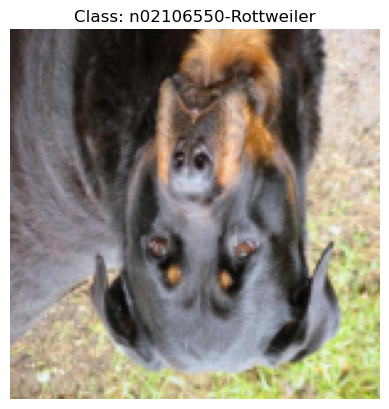

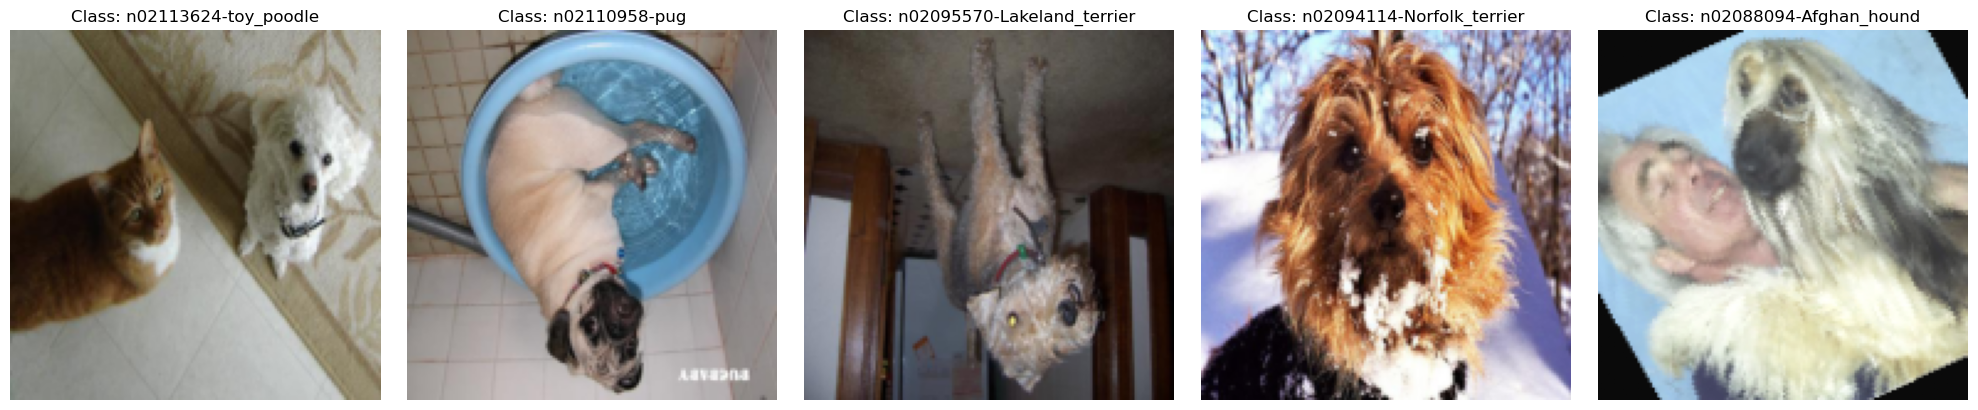

In [5]:
import matplotlib.pyplot as plt
import random

# Function to display a single image and its label
def display_image_and_label(dataset, index):
    # Choose the image and its label from the combined dataset
    img, label = dataset[index]
    
    # Convert the tensor image to numpy format for displaying
    img = img.permute(1, 2, 0).numpy()
    
    # Get the class name for the label
    # Since combined_dataset contains multiple datasets, we access the original datasets' classes
    class_name = dataset.datasets[0].classes[label]
    
    # Display the image with its label
    plt.imshow(img)
    plt.title(f"Class: {class_name}")
    plt.axis('off')
    plt.show()

# Choose a random image from the combined dataset
random_index = random.randint(0, len(combined_dataset) - 1)
display_image_and_label(combined_dataset, random_index)

# Show multiple images from the combined dataset
num_images_to_display = 5
fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 4))

for i in range(num_images_to_display):
    random_index = random.randint(0, len(combined_dataset) - 1)
    
    # Get the image and label from the combined dataset
    img, label = combined_dataset[random_index]
    
    # Convert to numpy format for plotting
    img = img.permute(1, 2, 0).numpy()
    
    # Plot the image with the corresponding label
    axes[i].imshow(img)
    axes[i].set_title(f"Class: {combined_dataset.datasets[0].classes[label]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


# Create the model

In [6]:
class CNNClassification(nn.Module):
    def __init__(self):
        super(CNNClassification, self).__init__()
        self.CNN_Model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(256 * 9 * 9, 2048),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.Dropout(0.1),
            nn.Linear(512, 120)  # 120 output breeds
        )

    def forward(self, x):
        return self.CNN_Model(x)

In [7]:
Cnn_model = CNNClassification()
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  # Use class weights for imbalance handling
optimizer = torch.optim.SGD(Cnn_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
Cnn_model.to(device)

# Learning Rate Scheduler with ReduceLROnPlateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

c:\Users\dmin\anaconda3\anaconda\envs\test_env\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


# Training

In [8]:
import copy

def test_the_model(model, test_dataloader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    running_loss = 0.0

    # Disable gradient calculation during testing
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    # Calculate test accuracy
    accuracy = (correct / total) * 100
    avg_loss = running_loss / len(test_dataloader)
    return accuracy, avg_loss

def train_the_model(num_epochs=5, grad_clip=1.0):
    accuracies = []
    test_accuracies = []
    max_accuracy = 0
    best_model = None

    for epoch in range(num_epochs):
        Cnn_model.train()  # Set model to training mode
        correct = 0
        total = 0
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = Cnn_model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Apply gradient clipping
            clip_gradient(optimizer, grad_clip)

            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

        train_accuracy = (correct / total) * 100
        accuracies.append(train_accuracy)

        # Evaluate the model on the test dataset after each epoch
        test_accuracy, test_loss = test_the_model(Cnn_model, val_dataloader)
        test_accuracies.append(test_accuracy)

        # Reduce learning rate based on validation loss
        scheduler.step(test_loss)

        # Save the best model based on test accuracy
        if test_accuracy > max_accuracy:
            best_model = copy.deepcopy(Cnn_model)
            max_accuracy = test_accuracy
            print(f"Saving best model with Test Accuracy: {test_accuracy:.2f}%")
        
        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {running_loss / len(train_dataloader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Test Loss: {test_loss:.4f}, "
              f"Test Accuracy: {test_accuracy:.2f}%")

    # Plot training and test accuracy over epochs
    plt.plot(accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Testing Accuracy Over Epochs")
    plt.legend()
    plt.show()

    return best_model

c:\Users\dmin\anaconda3\anaconda\envs\test_env\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Saving best model with Test Accuracy: 6.12%
Epoch 1/20, Train Loss: 4.4589, Train Accuracy: 3.91%, Test Loss: 4.2023, Test Accuracy: 6.12%
Saving best model with Test Accuracy: 8.97%
Epoch 2/20, Train Loss: 4.0597, Train Accuracy: 8.14%, Test Loss: 4.0740, Test Accuracy: 8.97%
Saving best model with Test Accuracy: 12.39%
Epoch 3/20, Train Loss: 3.7816, Train Accuracy: 11.94%, Test Loss: 3.7808, Test Accuracy: 12.39%
Saving best model with Test Accuracy: 15.33%
Epoch 4/20, Train Loss: 3.5462, Train Accuracy: 15.73%, Test Loss: 3.6077, Test Accuracy: 15.33%
Saving best model with Test Accuracy: 17.89%
Epoch 5/20, Train Loss: 3.3240, Train Accuracy: 19.39%, Test Loss: 3.5133, Test Accuracy: 17.89%
Saving best model with Test Accuracy: 17.90%
Epoch 6/20, Train Loss: 3.1201, Train Accuracy: 22.79%, Test Loss: 3.5153, Test Accuracy: 17.90%
Saving best model with Test Accuracy: 18.67%
Epoch 7/20, Train Loss: 2.9643, Train Accuracy: 26.03%, Test Loss: 3.5301, Test Accuracy: 18.67%
Saving best 

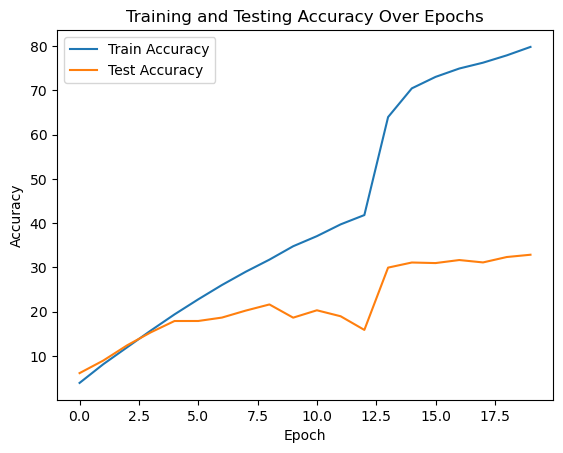

In [9]:
result_model = train_the_model(20)